In [1]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import os
import re
import xmltodict
from datetime import datetime

def xml_to_dict(element):
    """Recursively converts an XML element and its children to a dictionary."""
    if len(element) == 0:
        return element.text
    return {child.tag: xml_to_dict(child) for child in element}

def pretty(d, indent=0):
   for key, value in d.items():
      print('\t' * indent + str(key))
      if isinstance(value, dict):
         pretty(value, indent+1)
      else:
         print('\t' * (indent+1) + str(value))

In [2]:
race_quality_dict = {
    "TRL": 1,
    "MCL": 1,
    "WMC": 1,
    "MOC": 1.5,
    "MSA": 1.5,
    "MSW": 2.5,
    "WCL": 2,
    "CLM": 2,
    "MST": 2.5,
    "CLH": 2.5,
    "CST": 2.5,
    "SOC": 2.5,
    "OCL":	2.75,
    "SHP":	3,
    "STR":	2.75,
    "AOC": 3.25,
    "OCS": 3.5,
    "OCH":	3.25,
    "ALW":	4,
    "HCP":	4,
    "SIM":	2,
    "SST":	3.5,
    "STK": 5
}

In [3]:
# Step 2: Load and Parse XML Data using pandas.read_xml
def load_performance_data(file_path):
    # Parse the XML file
    tree = ET.parse(file_path)
    root = tree.getroot()
    print("Loading PP data for: ", os.path.basename(file_path))

    # Extract date from filename
    date_match = re.search(r'\d{8}', os.path.basename(file_path))
    race_date = ""
    if date_match:
        race_date = date_match.group(0)

    # Extract track from filename
    track_name = os.path.basename(file_path).split('_')[0][-3:]
    track_name = ''.join([i for i in track_name if not i.isdigit()])
    
    # Extract each Race element within EntryRaceCard and convert to a dictionary
    races = []
    for race in root.findall('.//Race'):
        race_dict = xmltodict.parse(ET.tostring(race))['Race']
        if race_dict['BreedType']['Value'] != 'TB':
            continue
        race_dict, race_date = extract_general_race_info(race_dict, race_date, track_name)

        for entry in race.findall('.//Starters'):
            entry_dict = extract_entry_info(entry, race_date)
            workout_dict = extract_workout_info(entry, race_date)
            races.append({**race_dict, **entry_dict, **workout_dict})
        
    # Convert the list of dictionaries into a DataFrame
    df = pd.DataFrame(races)

    return df

def extract_general_race_info(race_dict, race_date, track_name):
    # Extract date from filename
    race_id = f"{race_date}_{race_dict['RaceNumber']}_{track_name}"
    race_date = race_date
    return {
        "race_id": race_id,
        "course_type": str(race_dict['Course']['Surface']['Value']),
        "distance": int(race_dict['Distance']['DistanceId']),
        "race_type": str(race_dict['RaceType']['RaceType']),
        "restriction_type": str(race_dict['RestrictionType']['Value']),
        "condition": str(race_dict['ConditionsOfRace']).strip(),
        "purse": float(race_dict['PurseUSA']),
        "number_of_run": int(race_dict['NumberOfRunners'])
    }, race_date

def extract_entry_info(entry_root, race_date):
    entry_dict = xmltodict.parse(ET.tostring(entry_root))['Starters']

    # Convert odds from fraction to decimal
    odds_fraction = entry_dict['Odds']
    if isinstance(odds_fraction, str) and '/' in odds_fraction:
        numerator, denominator = map(float, odds_fraction.split('/'))
        odds_decimal = numerator / denominator
    else:
        odds_decimal = float(odds_fraction) if odds_fraction else None
    
    final_dict = {
        "horse_id": f"{entry_dict['Horse']['HorseName']}_{entry_dict['ProgramNumber']}",
        "gender": str(entry_dict['Horse']['Sex']['Value']),
        "post_position": int(entry_dict['PostPosition']),
        "weight": int(entry_dict['WeightCarried']),
        "equipment": str(entry_dict['Equipment']['Value']),
        "medication": str(entry_dict['Medication']['Value']),
        "trainer": int(entry_dict['Trainer']['ExternalPartyId']),
        "jockey": int(entry_dict['Jockey']['ExternalPartyId']),
        "odds": (odds_decimal),
    }

    summaries = entry_root.findall('.//RaceSummary')
    if summaries is list:
        summary_dict = xmltodict.parse(ET.tostring(summaries[0]))['RaceSummary']
        final_dict.update({
            "win_percentage_year": float(summary_dict['NumberOfWins']) / float(summary_dict['NumberOfStarts']),
            "otb_percentage_year": (float(summary_dict['NumberOfWins']) + float(summary_dict['NumberOfSeconds']) + float(summary_dict['NumberOfThirds'])) / float(summary_dict['NumberOfStarts']),
        })


    for i, pp in enumerate(entry_root.findall('.//PastPerformance')):
        if i > 5:
            break
        pp_dict = xmltodict.parse(ET.tostring(pp))['PastPerformance']

        race_type = str(pp_dict['RaceType']['RaceType'])
        race_quality = race_quality_dict[race_type] if str(race_type) in race_quality_dict.keys() else 1

        if str(pp_dict['RaceRestrictions']['RestrictionType']) == 'S':
            race_quality -= 1
        if race_type == 'STK' and pp_dict['Grade'] is not None:
            race_quality += 4 - int(pp_dict['Grade'])

        if i == 0:
            final_dict.update({
                "pp_layoff": (datetime.strptime(race_date, '%Y%m%d') - datetime.strptime(pp_dict['RaceDate'][:10], '%Y-%m-%d')).days
            })
 
        hot_splits = False
        if int(pp_dict['Distance']['DistanceId']) < 400:
            hot_splits = False
        elif int(pp_dict['Distance']['DistanceId']) == 400:
            hot_splits = int(pp_dict['Fractions'][0]['Time']) <= 2280 and int(pp_dict['Fractions'][-1]['Time']) <= 2240
        elif (len(pp_dict['Fractions']) < 3) or int(pp_dict['Distance']['DistanceId']) < 600:
            hot_splits = int(pp_dict['Fractions'][0]['Time']) <= 2340 and int(pp_dict['Fractions'][-1]['Time']) <= 2300
        elif int(pp_dict['Distance']['DistanceId']) == 600:
            hot_splits = int(pp_dict['Fractions'][0]['Time']) <= 2360 and int(pp_dict['Fractions'][1]['Time']) <= 2320
        else:
            hot_splits = int(pp_dict['Fractions'][0]['Time']) <= 2440 and int(pp_dict['Fractions'][1]['Time']) <= 2400 and int(pp_dict['Fractions'][2]['Time']) <= 2400

        bad_luck = False
        long_comment = str(pp_dict['Start']['LongComment']).lower()
        if long_comment is not None:
            if any(['bump' in long_comment, 'stumbled' in long_comment, 'checked' in long_comment, 'steadied' in long_comment, 'stopped' in long_comment, 'squeezed' in long_comment, 'steady' in long_comment or 'steadied' in long_comment, 'head turned' in long_comment, 'unprepared start' in long_comment, 'wd' in long_comment or 'wide' in long_comment, 'bled' in long_comment]):
                bad_luck = True

        final_dict.update({
            f"pp_track_{i}": str(pp_dict['Track']['TrackID']),
            f"pp_time_since_race_{i}": (datetime.strptime(race_date, '%Y%m%d') - datetime.strptime(pp_dict['RaceDate'][:10], '%Y-%m-%d')).days,
            f"pp_course_type_{i}": str(pp_dict['Course']['Surface']['Value']),
            f"pp_distance_{i}": int(pp_dict['Distance']['DistanceId']),
            f"pp_quality_{i}": race_quality,
            f"pp_purse_{i}": float(pp_dict['PurseUSA']),
            f"pp_normalized_position_{i}": np.divide(float(pp_dict['Start']['OfficialFinish']), float(pp_dict['NumberOfStarters'])),
            f"pp_class_rating_{i}": int(pp_dict['Start']['ClassRating']),
            f"pp_speed_rating_{i}": int(pp_dict['Start']['SpeedFigure']),
            f"pp_hot_splits_{i}": hot_splits,
            f"pp_bad_luck_{i}": bad_luck,
        })

    return final_dict

def extract_workout_info(entry_root, race_date):
    final_dict = {}
    for i, workout in enumerate(entry_root.findall('.//Workout')):        
        workout_dict = xmltodict.parse(ET.tostring(workout))['Workout']
        final_dict.update({
            f"workout_last_month_{i}": True if (datetime.strptime(race_date, '%Y%m%d')  - datetime.strptime(workout_dict['Date'][:10], '%Y-%m-%d')).days < 30 else False,
            f"workout_distance_{i}": int(workout_dict['Distance']['DistanceId']),
            f"workout_course_type_{i}": str(workout_dict['CourseType']['Surface']['Value']),
            f"workout_time_{i}": int(workout_dict['Timing']),
            f"workout_rank_{i}": int(workout_dict['Ranking']) / int(workout_dict['NumberInRankingGroup']),
        })

    return final_dict


performance_path = "C:\\Users\\dylan\\OneDrive - Wayne State College\\Documents\\Equibase Data 2023\\2023 PPs\\Extracted PPs"
file_suffixes = ['FON_USA.xml', 'PRM_USA.xml']  # Add your suffixes here

# Load all past performance files
performance_data = pd.concat([load_performance_data(os.path.join(root, file)) 
                              for root, _, files in os.walk(performance_path) 
                              for file in files if file.endswith(tuple(file_suffixes))])

Loading PP data for:  SIMD20230210FON_USA.xml
Loading PP data for:  SIMD20230211FON_USA.xml
Loading PP data for:  SIMD20230212FON_USA.xml
Loading PP data for:  SIMD20230217FON_USA.xml
Loading PP data for:  SIMD20230218FON_USA.xml
Loading PP data for:  SIMD20230219FON_USA.xml
Loading PP data for:  SIMD20230224FON_USA.xml
Loading PP data for:  SIMD20230225FON_USA.xml
Loading PP data for:  SIMD20230226FON_USA.xml
Loading PP data for:  SIMD20230303FON_USA.xml
Loading PP data for:  SIMD20230304FON_USA.xml
Loading PP data for:  SIMD20230305FON_USA.xml
Loading PP data for:  SIMD20230310FON_USA.xml
Loading PP data for:  SIMD20230311FON_USA.xml
Loading PP data for:  SIMD20230312FON_USA.xml
Loading PP data for:  SIMD20230317FON_USA.xml
Loading PP data for:  SIMD20230318FON_USA.xml
Loading PP data for:  SIMD20230319FON_USA.xml
Loading PP data for:  SIMD20230324FON_USA.xml
Loading PP data for:  SIMD20230325FON_USA.xml
Loading PP data for:  SIMD20230326FON_USA.xml
Loading PP data for:  SIMD20230331

In [4]:
def load_results_data(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()

    print("Loading res data for: ", os.path.basename(file_path))

    entries = []
    for race in root.findall('.//RACE'):
        race_date = re.search(r'\d{8}', os.path.basename(file_path)).group(0)
        race_number = race.get("NUMBER")
        track_name = os.path.basename(file_path).split('_')[0][:3].upper()
        track_name = ''.join([i for i in track_name if not i.isdigit()])

        for entry in race.findall('.//ENTRY'):
            horse_name = entry.find(".//NAME").text
            horse_number = entry.find(".//PROGRAM_NUM").text
            entry_data = {
                "horse_id": f"{horse_name}_{horse_number}",
                "race_id": f"{race_date}_{race_number}_{track_name}",
                "Position": int(entry.find(".//POINT_OF_CALL[@WHICH='FINAL']").find('.//POSITION').text),
            }
            entries.append(entry_data)
    
    return entries

results_path = "C:\\Users\\dylan\\OneDrive - Wayne State College\\Documents\\Equibase Data 2023\\2023 Result Charts"
file_prefixes = ['fon', 'prm']  # Add your suffixes here


# Load all results files
all_races = []
for file in os.listdir(results_path):
    if file.endswith('.xml') and file.startswith(tuple(file_prefixes)):
        file_path = os.path.join(results_path, file)
        all_races.extend(load_results_data(file_path))

results_data = pd.DataFrame(all_races)

Loading res data for:  fon20230210tch.xml
Loading res data for:  fon20230211tch.xml
Loading res data for:  fon20230212tch.xml
Loading res data for:  fon20230217tch.xml
Loading res data for:  fon20230218tch.xml
Loading res data for:  fon20230219tch.xml
Loading res data for:  fon20230224tch.xml
Loading res data for:  fon20230225tch.xml
Loading res data for:  fon20230226tch.xml
Loading res data for:  fon20230303tch.xml
Loading res data for:  fon20230304tch.xml
Loading res data for:  fon20230305tch.xml
Loading res data for:  fon20230310tch.xml
Loading res data for:  fon20230311tch.xml
Loading res data for:  fon20230312tch.xml
Loading res data for:  fon20230317tch.xml
Loading res data for:  fon20230318tch.xml
Loading res data for:  fon20230319tch.xml
Loading res data for:  fon20230324tch.xml
Loading res data for:  fon20230325tch.xml
Loading res data for:  fon20230326tch.xml
Loading res data for:  fon20230331tch.xml
Loading res data for:  fon20230401tch.xml
Loading res data for:  fon20230402

In [5]:
# Step 3: Combine Data

# Merge the DataFrames on RaceNumber and race_date
merged_data = pd.merge(performance_data, results_data, on=["race_id", "horse_id"], how='inner')

# Create normalized position
merged_data['normalized_position'] = np.multiply(np.divide(merged_data['Position'], merged_data['number_of_run']), 100)

# Clean up old DataFrames
# del performance_data
# del results_data

In [6]:
# Go through each row and create new columns
for i, row in merged_data.iterrows():
    # Initialize new columns
    merged_data.at[i, "first_off_layoff"] = False
    merged_data.at[i, "second_off_layoff"] = False
    merged_data.at[i, "third_off_layoff"] = False
    
    # Set if horse is off layoff
    if row['pp_time_since_race_0'] > 45:
        merged_data.at[i, 'first_off_layoff'] = True
    elif row['pp_time_since_race_1'] - row['pp_time_since_race_0'] > 45:
        merged_data.at[i, 'second_off_layoff'] = True
    elif row['pp_time_since_race_2'] - row['pp_time_since_race_1'] > 45:
        merged_data.at[i, 'third_off_layoff'] = True

    # Get jockey trainer win percentage
    # Find each jockey row with the same value and check if the position is 1
    jockey_win_percentage = merged_data.groupby('jockey')['Position'].transform(lambda x: (x == 1).sum() / len(x))

    # Divide that by the total rows with that jockey id
    merged_data['jockey_win_percentage'] = jockey_win_percentage

    # Find each trainer row with the same value and check if the position is 1
    trainer_win_percentage = merged_data.groupby('trainer')['Position'].transform(lambda x: (x == 1).sum() / len(x))

    # Divide that by the total rows with that trainer id
    merged_data['trainer_win_percentage'] = trainer_win_percentage

    # Find each trainer row and jockey row with the same value and check if the position is 1
    trainer_jockey_win_percentage = merged_data.groupby(['trainer', 'jockey'])['Position'].transform(lambda x: (x == 1).sum() / len(x))

    # Divide that by the total rows with that jockey and trainer id
    merged_data['trainer_jockey_win_percentage'] = trainer_jockey_win_percentage

C:\Users\dylan\AppData\Local\Temp\ipykernel_15552\3762836842.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged_data.at[i, "first_off_layoff"] = False
C:\Users\dylan\AppData\Local\Temp\ipykernel_15552\3762836842.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged_data.at[i, "second_off_layoff"] = False
C:\Users\dylan\AppData\Local\Temp\ipykernel_15552\3762836842.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged_data.at[i, "third_off_layoff"] = False


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

merged_data.reset_index()

# Drop unneeded columns
# merged_data = merged_data.drop(columns=['race_id', 'horse_id'])

# Identify columns with missing values
columns_with_missing = merged_data.columns[merged_data.isnull().any()]

# Impute only columns with missing values
imputer = SimpleImputer(strategy='most_frequent')
imputed_array = imputer.fit_transform(merged_data[columns_with_missing])

# Convert the imputed array back to a DataFrame with original column names
imputed_data = pd.DataFrame(imputed_array, columns=columns_with_missing)

# Combine the imputed columns with the rest of the data
merged_data_imputed = merged_data.copy()
merged_data_imputed[columns_with_missing] = imputed_data

# Use LabelEncoder on string columns
label_encoder = LabelEncoder()
for col in merged_data_imputed.columns:
    if merged_data_imputed[col].dtype == 'object':
        merged_data_imputed[col] = label_encoder.fit_transform(merged_data_imputed[col])


In [8]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import RandomForestRegressor

X = merged_data_imputed.drop(columns=['normalized_position', 'Position'])
y = merged_data_imputed['normalized_position']
groups = merged_data_imputed['race_id']  # Assuming 'race_id' is the column name for race IDs

# Split the data
gss = GroupShuffleSplit(test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Store the 'odds' column for later use
odds_train = X_train['odds']
odds_test = X_test['odds']

# Drop the 'odds' column from the training and testing datasets
X_train = X_train.drop(columns=['odds'])
X_test = X_test.drop(columns=['odds'])

# Initialize the model with possible hyperparameters
# param_grid = {
#     'max_features': [.5,60],
#     'max_depth': [10, 20],
#     'min_samples_leaf': [10],
#     'n_estimators': [225, 300, 400]
# }
# grid_search = GridSearchCV(estimator=RandomForestRegressor(n_jobs=-1),
#                            param_grid=param_grid,
#                            cv=5,  # 5-fold cross-validation
#                            n_jobs=1,  # Use all available cores
#                            verbose=3)
model = RandomForestRegressor(n_jobs=-1, max_depth=20, max_features=.5, min_samples_leaf=10, n_estimators=300)

# Train the model
model_results = model.fit(X_train, y_train)

In [9]:
# # Retrieve the best parameters and model
# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_
# print(f"Best Parameters: {best_params}")

In [10]:
predicted_normalized_position = model.predict(X_test)
predicted_finish_position = np.divide(np.multiply(predicted_normalized_position, X_test['number_of_run']), 100)

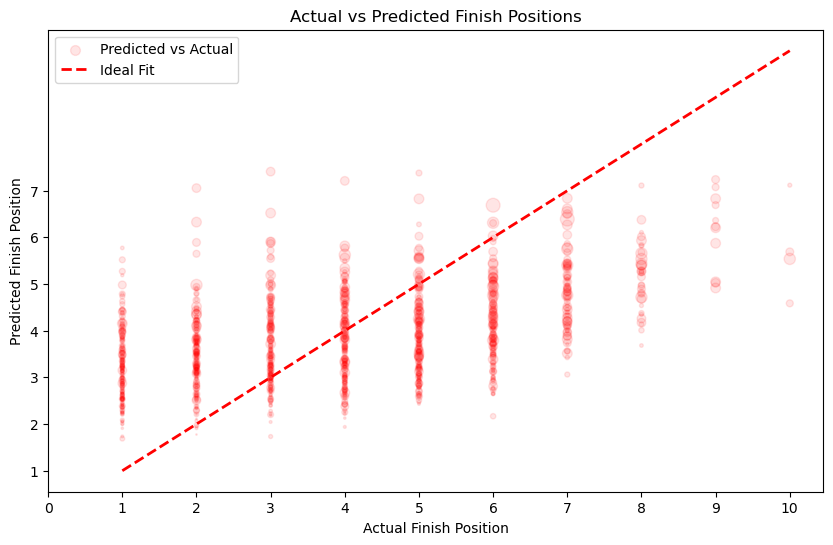

In [11]:
import matplotlib.pyplot as plt

# Assuming imputed_merged_data and predicted_finish_position are already defined

# Extract actual finish positions
actual_finish_position = np.divide(np.multiply(y_test, X_test['number_of_run']), 100)

# Extract and normalize the Odds column
odds = odds_test
normalized_odds = np.multiply(np.divide((odds - odds.min()), (odds.max() - odds.min())), 100)  # Scale to a range of 0 to 100

# Plot actual vs predicted finish positions with bubble sizes relative to Odds
plt.figure(figsize=(10, 6))
plt.scatter(actual_finish_position, predicted_finish_position, s=normalized_odds, color='red', alpha=0.1, label='Predicted vs Actual')
plt.plot([actual_finish_position.min(), actual_finish_position.max()], 
         [actual_finish_position.min(), actual_finish_position.max()], 
         'r--', lw=2, label='Ideal Fit')
plt.xlabel('Actual Finish Position')
plt.ylabel('Predicted Finish Position')
plt.title('Actual vs Predicted Finish Positions')
plt.legend()

# Set the tick labels to show every number
plt.xticks(range(int(actual_finish_position.min()), int(actual_finish_position.max()) + 1))
plt.yticks(range(int(predicted_finish_position.min()), int(predicted_finish_position.max()) + 1))

plt.show()

In [12]:
# Create a DataFrame by concatenating the series
results_df = pd.concat([X_test['race_id'], actual_finish_position, predicted_finish_position, odds], axis=1)

# Rename the columns for clarity
results_df.columns = ['race_id', 'actual_finish_position', 'predicted_finish_position', 'odds']


In [13]:
# Create another dataframe from results_df that selects the lowest predicted_finish_position for each race_id
best_predictions = results_df.groupby('race_id').agg({'predicted_finish_position': 'min'}).reset_index()
# Merge the best_predictions dataframe with results_df to get all other columns
merged_best_predictions = pd.merge(best_predictions, results_df, on=["race_id", "predicted_finish_position"], how='inner')

In [14]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Assuming actual_finish_position and predicted_finish_position are already defined

# Calculate Mean Squared Error
mse = mean_squared_error(actual_finish_position, predicted_finish_position)
print(f"Mean Squared Error: {mse}")

# Calculate R-squared value
r2 = r2_score(actual_finish_position, predicted_finish_position)
print(f"R-squared: {r2}")

# Calculate mean absolute error
mae = mean_absolute_error(actual_finish_position, predicted_finish_position)
print(f"Mean Absolute Error: {mae}")

# Mean Squared Error: 3.6467563389723368
# R-squared: 0.2401546886605097
# Mean Absolute Error: 1.579545291325833

Mean Squared Error: 3.243147049158259
R-squared: 0.23397850703713585
Mean Absolute Error: 1.5186755833833345
